# MONGY: Training `PatchTSMixer` on Financial Candlestick Data
## Direct forecasting example

This notebooke demonstrates the usage of a `PatchTSMixer` model for a multivariate time series forecasting task. This notebook has a dependecy on HuggingFace [transformers](https://github.com/huggingface/transformers) repo. For details related to model architecture, refer to the [TSMixer paper](https://arxiv.org/abs/2306.09364).

In [1]:
# Standard
import os
import random

# Third Party
from transformers import (
    EarlyStoppingCallback,
    PatchTSMixerConfig,
    PatchTSMixerForPrediction,
    Trainer,
    TrainingArguments,
)
import numpy as np
import pandas as pd
import torch

# First Party
from tsfm_public.toolkit.dataset import ForecastDFDataset, BaseDFDataset
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor

In [2]:
# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [3]:
# We want to setup our context, horizon, and patch size based on our task. We want to use
# 4 hours of lookback to start, in order to predict the next 5 minutes of candles. Regarding
# patch length, we know that we will want a larger patch size, so we will start with 64 as
# a base case assumption
context_length = 60 * 4  # This will give us 4 hours of lookback (6 candles per min * 60 min per hour)
forecast_horizon = 3 # This will give us 3 minutes of predictions

In [4]:
# Load the Dataset from the CSV file
DATA_DIR = "/home/ubuntu/verb-workspace/data"

TEST_DATASET = f"{DATA_DIR}/1min-candles-test-w-VWAP.csv"

timestamp_col = 't'

test_data = pd.read_csv(
    TEST_DATASET,
    parse_dates=[timestamp_col]
)


In [5]:
test_data.head()

,ticker,date_string,t,targ_o,targ_h,targ_l,targ_c,targ_v,obs_vwap,cont_market_open,cont_market_extended
0,AAPL,2023-01-23,2023-01-23 05:30:00-05:00,137.32,137.32,137.32,137.32,270.0,137.3304,0,1
1,AAPL,2023-01-23,2023-01-23 05:31:00-05:00,137.32,137.35,137.25,137.25,2893.0,137.3064,0,1
2,AAPL,2023-01-23,2023-01-23 05:32:00-05:00,137.25,137.25,137.22,137.22,1208.0,137.2449,0,1
3,AAPL,2023-01-23,2023-01-23 05:33:00-05:00,137.22,137.25,137.22,137.25,3444.0,137.2497,0,1
4,AAPL,2023-01-23,2023-01-23 05:34:00-05:00,137.25,137.25,137.25,137.25,0.0,0.0000,0,1


In [6]:
# Check for NaN values
assert sum(test_data.isna().sum().to_list()) == 0

In [12]:


id_columns = ['ticker', 'date_string']
forecast_columns = ['targ_o', 'targ_c', 'targ_h', 'targ_l', 'targ_v']
observable_columns = ['obs_vwap']
control_columns = ['cont_market_open', 'cont_market_extended']

test_tsp = TimeSeriesPreprocessor(
    timestamp_column=timestamp_col,
    id_columns=id_columns,
    target_columns=forecast_columns,
    observable_columns=observable_columns,
    control_columns=control_columns,
    scaling=False,
)
test_tsp.train(test_data)
print("Done Test")


Done Test


In [13]:
test_dataset = ForecastDFDataset(
    test_tsp.preprocess(test_data),
    id_columns=id_columns,
    timestamp_column=timestamp_col,
    target_columns=forecast_columns,
    control_columns=control_columns,
    context_length=context_length,
    observable_columns=observable_columns,
    prediction_length=forecast_horizon,
)

## Training `PatchTSMixer` From Scratch

Adjust the following model parameters according to need.
- `d_model` (`int`, *optional*, defaults to 8):
    Hidden dimension of the model. Recommended to set it as a multiple of patch_length (i.e. 2-8X of
    patch_len). Larger value indicates more complex model.
- `expansion_factor` (`int`, *optional*, defaults to 2):
    Expansion factor to use inside MLP. Recommended range is 2-5. Larger value indicates more complex model.
- `num_layers` (`int`, *optional*, defaults to 3):
    Number of layers to use. Recommended range is 3-15. Larger value indicates more complex model.
- `mode`: (`str`, either to 'common_channel' or `mix_channel`)

In [72]:
run_num = "vwap_4"
# run_num = "4_1min"
model_dir = f"./checkpoints/run_{run_num}/output/checkpoint-50000"
model = PatchTSMixerForPrediction.from_pretrained(model_dir)
model.eval()

PatchTSMixerForPrediction(
  (model): PatchTSMixerModel(
    (encoder): PatchTSMixerEncoder(
      (patcher): Linear(in_features=16, out_features=64, bias=True)
      (mlp_mixer_encoder): PatchTSMixerBlock(
        (mixers): ModuleList(
          (0-2): 3 x PatchTSMixerLayer(
            (patch_mixer): PatchMixerBlock(
              (norm): PatchTSMixerNormLayer(
                (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
              )
              (mlp): PatchTSMixerMLP(
                (fc1): Linear(in_features=225, out_features=450, bias=True)
                (dropout1): Dropout(p=0.5, inplace=False)
                (fc2): Linear(in_features=450, out_features=225, bias=True)
                (dropout2): Dropout(p=0.5, inplace=False)
              )
              (gating_block): PatchTSMixerGatedAttention(
                (attn_layer): Linear(in_features=225, out_features=225, bias=True)
                (attn_softmax): Softmax(dim=-1)
              )
            )


In [73]:
from torchsummary import summary

# # Provide the input size of your model
# summary(model, (240, 512))

## Model Test Bench

In [74]:
import time
from typing import Tuple

def run_inference(context: torch.Tensor, futures: torch.Tensor, log_time: bool = False) -> torch.Tensor:
    model.eval()
    
    with torch.no_grad():
        start = time.perf_counter()
        _forecasts = model(context.unsqueeze(0), future_values=futures.unsqueeze(0)).prediction_outputs
        end = time.perf_counter()

        if log_time:
            print(f"Ran Inference in {end - start} seconds")
        return _forecasts.squeeze(0)

In [75]:
def post_process(_context: torch.Tensor, _futures: torch.Tensor, _forecasts: torch.Tensor) -> Tuple[torch.tensor]:
    forecasts_ohlc = pd.DataFrame({
        'Open': _forecasts[:,0].numpy(),
        'Close': _forecasts[:,1].numpy(),
        'High': _forecasts[:,2].numpy(),
        'Low': _forecasts[:,3].numpy(),
    })
    
    # Convert futures to OHLC candle data
    futures_ohlc = pd.DataFrame({
        'Open': _futures[:,0].numpy(),
        'Close': _futures[:,1].numpy(),
        'High': _futures[:,2].numpy(),
        'Low': _futures[:,3].numpy(),
    })
    
    # Convert context data to OHLC candle data
    context_ohlc = pd.DataFrame({
        'Open': _context[:,0].numpy(),
        'Close': _context[:,1].numpy(),
        'High': _context[:,2].numpy(),
        'Low': _context[:,3].numpy(),
    })
    
    reals_ohlc = pd.concat([context_ohlc, futures_ohlc])
    return reals_ohlc, forecasts_ohlc

In [76]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd

def plot_candles(reals: pd.DataFrame, forecasts: pd.DataFrame, context_start_ts: pd.Timestamp) -> None:
    
    # Create custom styles for context, future, and forecast candles
    reals_style = mpf.make_mpf_style(base_mpf_style='yahoo', rc={'figure.facecolor': 'w', 'axes.facecolor': 'w'})
    forecast_style = {
        'marketcolors': {
            'candle': {'up': 'white', 'down': 'black'},
            'edge': {'up': 'black', 'down': 'black'},
            'wick': {'up': 'black', 'down': 'black'},
            'ohlc': {'up': 'white', 'down': 'black'},
            'volume': {'up': 'white', 'down': 'black'},
            'vcedge': {'up': 'white', 'down': 'black'},
            'vcdopcod': False,
            'alpha': 0.9
        }, 
                'mavcolors': None,
        'y_on_right': True,
    }
    
    # Create a figure and axis
    fig, ax1 = plt.subplots(figsize=(12, 4))
    
    # Create a time series with a duration of 4 hours and 20 minutes at a 1-minute frequency
    end_time = context_start_ts + pd.Timedelta(hours=4, minutes=2)  # Should get us the 4 hrs, 3min of time stamps
    reals_index = pd.date_range(start=context_start_ts, end=end_time, freq='1min')
    
    # Set the created time series as the index of reals_ohlc
    reals.index = reals_index
    
    # Get the last 3 minutes of the reals index
    last_3_minutes = reals.index[-3:]
    
    # Create a new DataFrame to store the padded forecast candles
    padded_forecasts = pd.DataFrame(0.0, index=reals_index, columns=forecasts.columns)
    padded_forecasts.iloc[-3:] = forecasts

    # Trim each df, to only contain 1 hour of data
    reals = reals.iloc[-60:]
    padded_forecasts = padded_forecasts.iloc[-60:]
    
    # Plot the real candles on the first axis
    mpf.plot(reals, type='candle', ax=ax1, style=reals_style)
    
    # Plot the padded forecast candles on top of the real candles
    mpf.plot(padded_forecasts, type='candle', ax=ax1, style=forecast_style)
    
    # Set the same y-limits for both axes
    y_min = min(reals['Low'].min(), forecasts['Low'].min())
    y_max = max(reals['High'].max(), forecasts['High'].max())
    ax1.set_ylim(y_min, y_max)
    
    # Set plot title and labels
    ax1.set_title('Aggregated 1-Minute Candles')
    ax1.set_xlabel('Candle Index')
    ax1.set_ylabel('Price')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

In [128]:
# Indices for accessing the OHLC values in the tensors
I_OPEN = 0
I_CLOSE = 1
I_HIGH = 2
I_LOW = 3

def theta_body(y_pred: torch.Tensor, y_obs: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    pred_body = y_pred[..., I_OPEN] - y_pred[..., I_CLOSE]
    obs_body = y_obs[..., I_OPEN] - y_obs[..., I_CLOSE]
    error = obs_body - pred_body
    squared_error = torch.square(error)
    abs_error = torch.abs(error)
    return squared_error, abs_error

def theta_wick_h(y_pred: torch.Tensor, y_obs: torch.Tensor, pred_max: torch.Tensor, obs_max: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    pred_wick_len = y_pred[..., I_HIGH] - pred_max
    obs_wick_len = y_obs[..., I_HIGH] - obs_max
    error = obs_wick_len - pred_wick_len
    squared_error = torch.square(error)
    abs_error = torch.abs(error)
    return squared_error, abs_error

def theta_wick_l(y_pred: torch.Tensor, y_obs: torch.Tensor, pred_min: torch.Tensor, obs_min: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    pred_wick_len = pred_min - y_pred[..., I_LOW]
    obs_wick_len = obs_min - y_obs[..., I_LOW]
    error = obs_wick_len - pred_wick_len
    squared_error = torch.square(error)
    abs_error = torch.abs(error)
    return squared_error, abs_error

def custom_loss(y_pred: torch.Tensor, y_obs: torch.Tensor) -> torch.Tensor:
    # Compute maximum and minimum values
    pred_max = torch.max(y_pred[..., [I_OPEN, I_CLOSE]], dim=-1)[0]
    obs_max = torch.max(y_obs[..., [I_OPEN, I_CLOSE]], dim=-1)[0]
    pred_min = torch.min(y_pred[..., [I_OPEN, I_CLOSE]], dim=-1)[0]
    obs_min = torch.min(y_obs[..., [I_OPEN, I_CLOSE]], dim=-1)[0]

    # Compute squared and absolute errors for each component
    body_sq_error, body_abs_error = theta_body(y_pred, y_obs)
    wick_h_sq_error, wick_h_abs_error = theta_wick_h(y_pred, y_obs, pred_max, obs_max)
    wick_l_sq_error, wick_l_abs_error = theta_wick_l(y_pred, y_obs, pred_min, obs_min)

    # Compute MSE and MAE
    theta_mse = torch.mean(body_sq_error + wick_h_sq_error + wick_l_sq_error)
    theta_mae = torch.mean(body_abs_error + wick_h_abs_error + wick_l_abs_error)

    mse = torch.nn.functional.mse_loss(y_pred, y_obs)
    mae = torch.nn.functional.l1_loss(y_pred, y_obs)
    
    # Combine the squared error and absolute error
    return ((theta_mse + mse) + (theta_mae + mae)) / 2

def custom_body_loss(y_pred: torch.Tensor, y_obs: torch.Tensor) -> torch.Tensor:
    # Compute squared and absolute errors for each component
    body_se, body_ae = theta_body(y_pred, y_obs)

    # Compute MSE and MAE
    mse = torch.nn.functional.mse_loss(y_pred, y_obs)
    mae = torch.nn.functional.l1_loss(y_pred, y_obs)

    custom_mse = torch.mean(mse + (2 * body_se / (1 + mse)))
    custom_mae = torch.mean(mae + (2 * body_ae / (1 + mae)))

    return (custom_mse + custom_mae) / 2

In [132]:
def infer_and_plot(example: dict, plot: bool = True) -> None:
    # Get the metadata for the example
    ticker, date_str = example['id']
    ts = pd.Timestamp(example['timestamp']).tz_localize("UTC").tz_convert("America/New_York")
    context_start = ts - pd.Timedelta(hours=3, minutes=59)

    print(f"{ticker} {date_str}: {ts.strftime('%I:%M %p')}")
    print("================================")
    # Get an example for inference
    _context = example['past_values']
    _futures = example['future_values']
    
    _forecasts = run_inference(_context, _futures)
    
    mse = torch.nn.functional.mse_loss(_forecasts[:, :4], _futures[:, :4])
    mae = torch.nn.functional.l1_loss(_forecasts[:, :4], _futures[:, :4])

    _, body_loss_ae = theta_body(_forecasts[:, :4], _futures[:, :4])
    
    base_loss = (mse + mae) / 2
    old_custom_loss_val = custom_loss(_forecasts[:, :4], _futures[:, :4])
    new_custom_loss_val = custom_body_loss(_forecasts[:, :4], _futures[:, :4])
    
    # Print the evaluation metrics
    print("Base Loss for first 4 columns:", base_loss.item())
    print("Body Losses:", body_loss_ae)
    print("Old Custom Loss:", old_custom_loss_val.item())
    print("New Custom Loss:", new_custom_loss_val.item())

    reals_ohlc, forecasts_ohlc = post_process(_context, _futures, _forecasts)
    if plot: plot_candles(reals_ohlc, forecasts_ohlc, context_start)
    return _forecasts

AAPL 2023-01-23: 09:30 AM
Base Loss for first 4 columns: 0.4439142942428589
Body Losses: tensor([0.0729, 0.7005, 0.3391])
Old Custom Loss: 0.7892309427261353
New Custom Loss: 0.8386813402175903


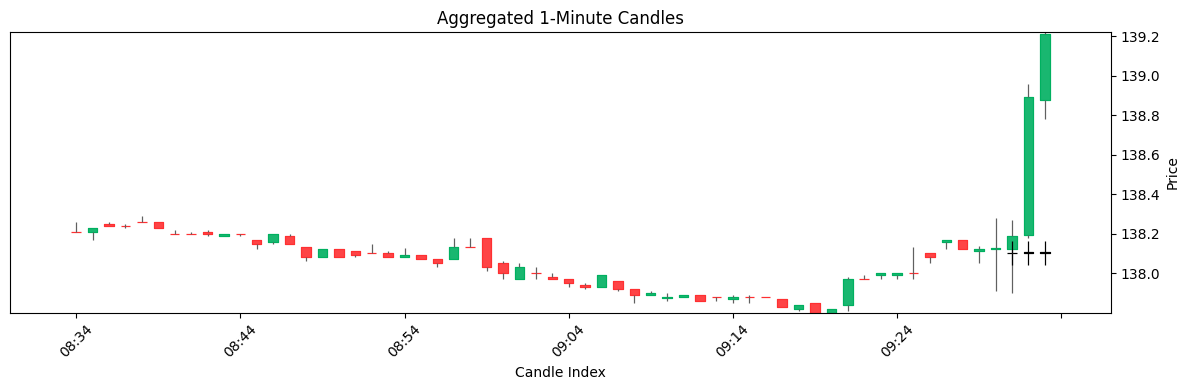

AAPL 2023-11-02: 02:01 PM
Base Loss for first 4 columns: 0.014063837006688118
Body Losses: tensor([0.0730, 0.0015, 0.0333])
Old Custom Loss: 0.057292502373456955
New Custom Loss: 0.05117129534482956


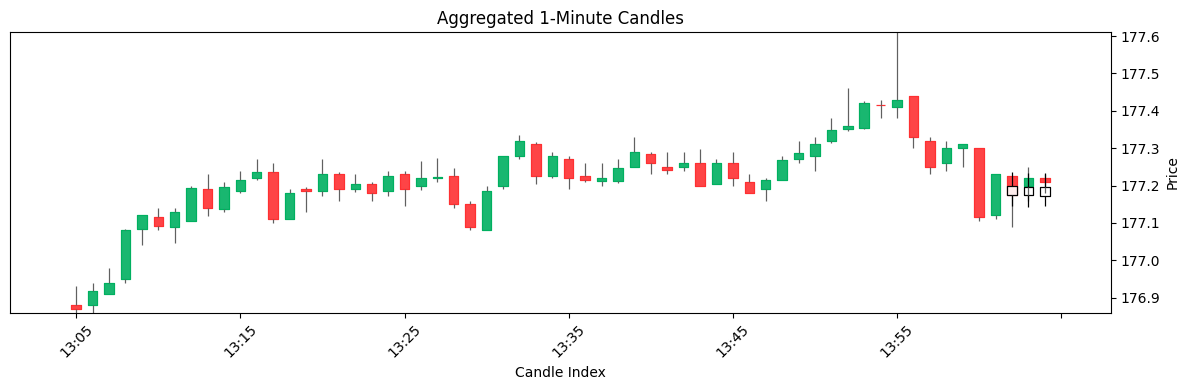

AMZN 2023-08-18: 12:04 PM
Base Loss for first 4 columns: 0.01459593791514635
Body Losses: tensor([0.0486, 0.0219, 0.0614])
Old Custom Loss: 0.05048457160592079
New Custom Loss: 0.05955338105559349


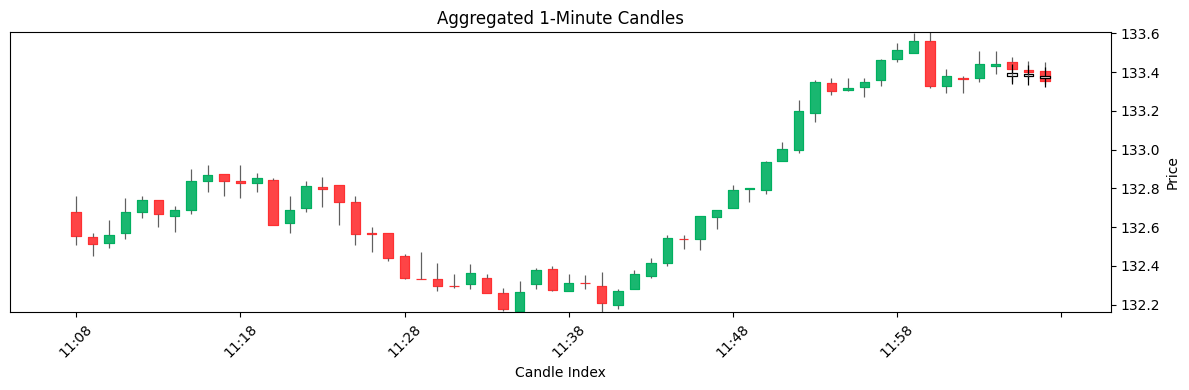

BAC 2023-06-01: 10:07 AM
Base Loss for first 4 columns: 0.0029251915402710438
Body Losses: tensor([0.0103, 0.0059, 0.0047])
Old Custom Loss: 0.013072539120912552
New Custom Loss: 0.009878234006464481


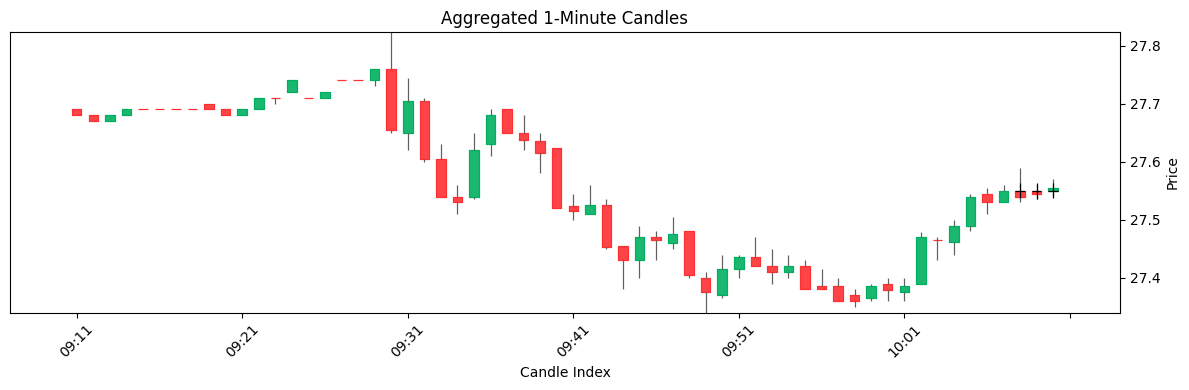

GOOGL 2023-04-13: 02:38 PM
Base Loss for first 4 columns: 0.032241396605968475
Body Losses: tensor([0.0438, 0.0479, 0.0423])
Old Custom Loss: 0.06961434334516525
New Custom Loss: 0.07637029141187668


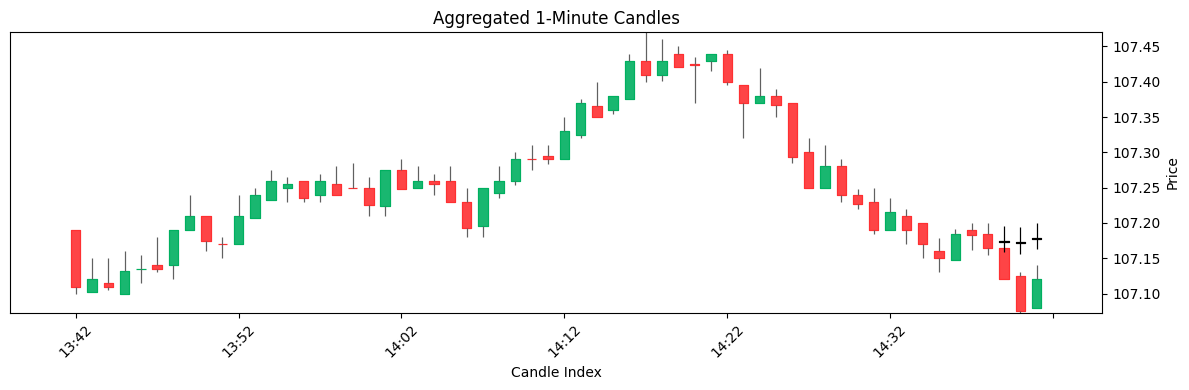

GOOGL 2023-10-27: 12:41 PM
Base Loss for first 4 columns: 0.06643451005220413
Body Losses: tensor([0.0964, 0.0388, 0.0672])
Old Custom Loss: 0.12639372050762177
New Custom Loss: 0.1318860650062561


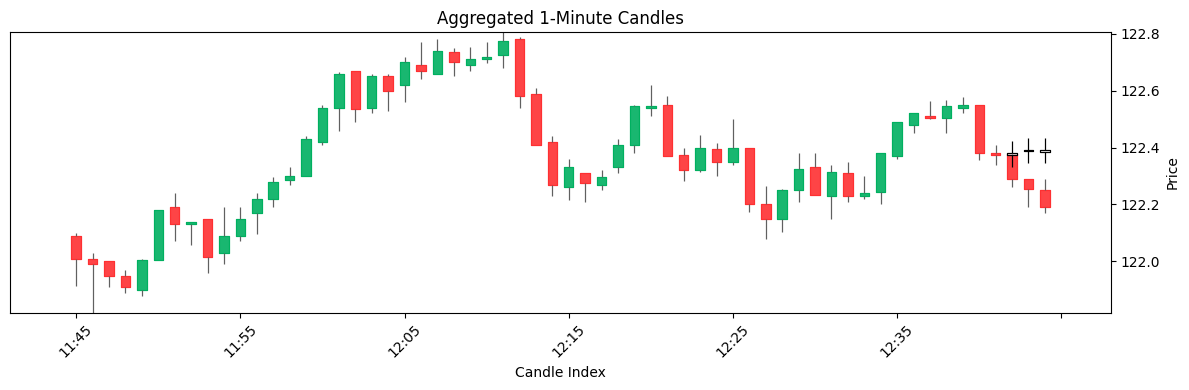

META 2023-08-10: 10:44 AM
Base Loss for first 4 columns: 0.7355793118476868
Body Losses: tensor([0.7661, 0.2289, 0.3569])
Old Custom Loss: 1.1946983337402344
New Custom Loss: 1.1397608518600464


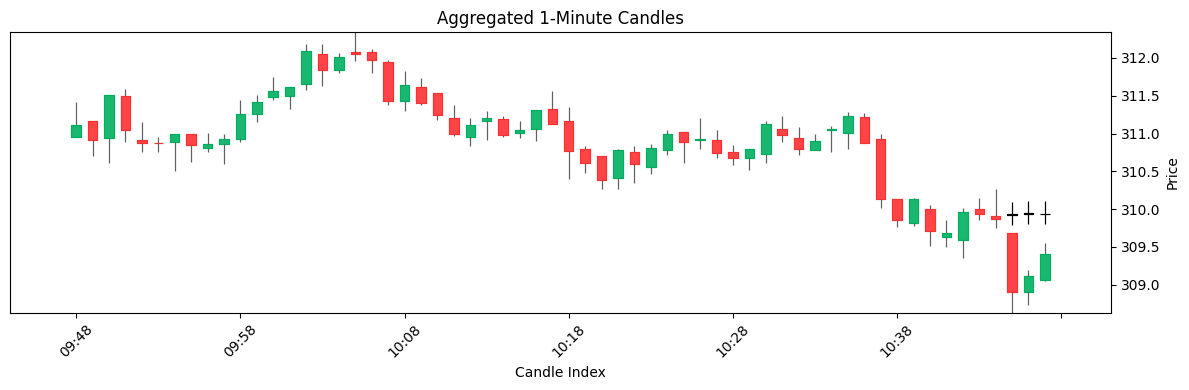

MSFT 2023-05-01: 03:15 PM
Base Loss for first 4 columns: 0.05472932383418083
Body Losses: tensor([0.0290, 0.0807, 0.1103])
Old Custom Loss: 0.12829317152500153
New Custom Loss: 0.1279396116733551


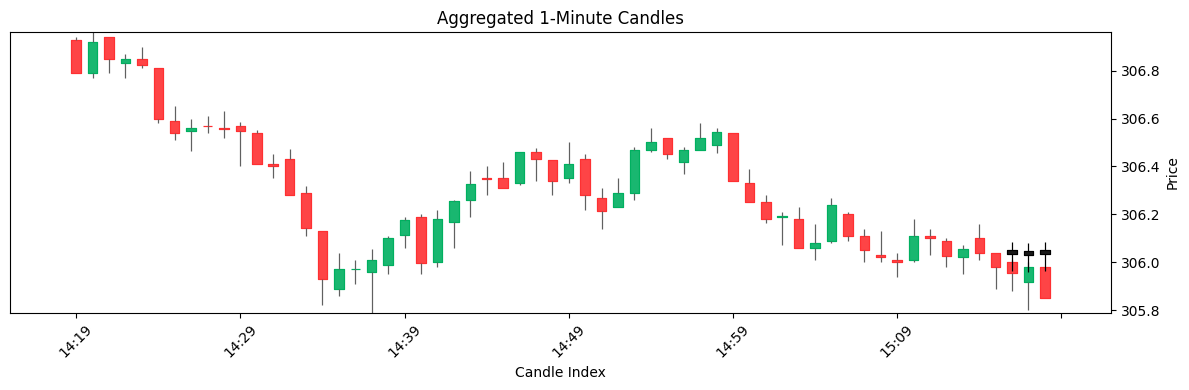

NVDA 2023-04-20: 01:18 PM
Base Loss for first 4 columns: 0.07054698467254639
Body Losses: tensor([0.0231, 0.0739, 0.2336])
Old Custom Loss: 0.18132759630680084
New Custom Loss: 0.18844643235206604


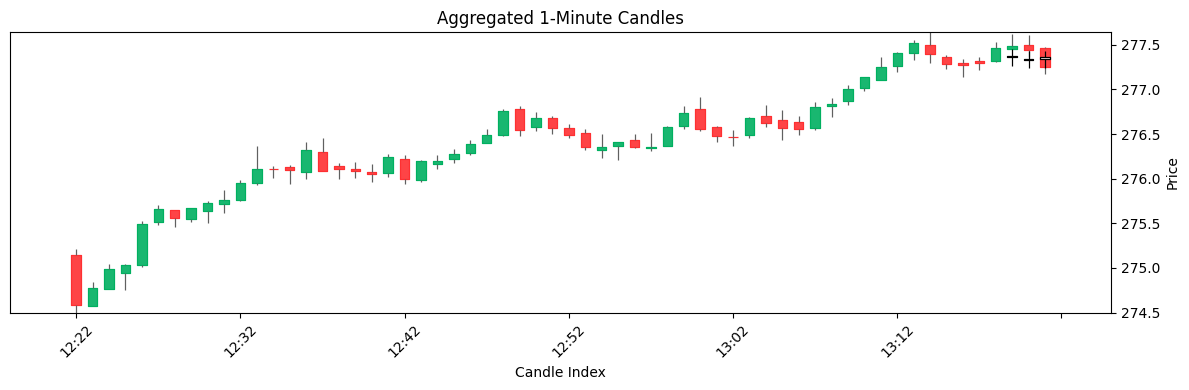

NVDA 2023-11-16: 11:21 AM
Base Loss for first 4 columns: 0.3101840317249298
Body Losses: tensor([0.3960, 0.0927, 0.4009])
Old Custom Loss: 0.6888698935508728
New Custom Loss: 0.6105345487594604


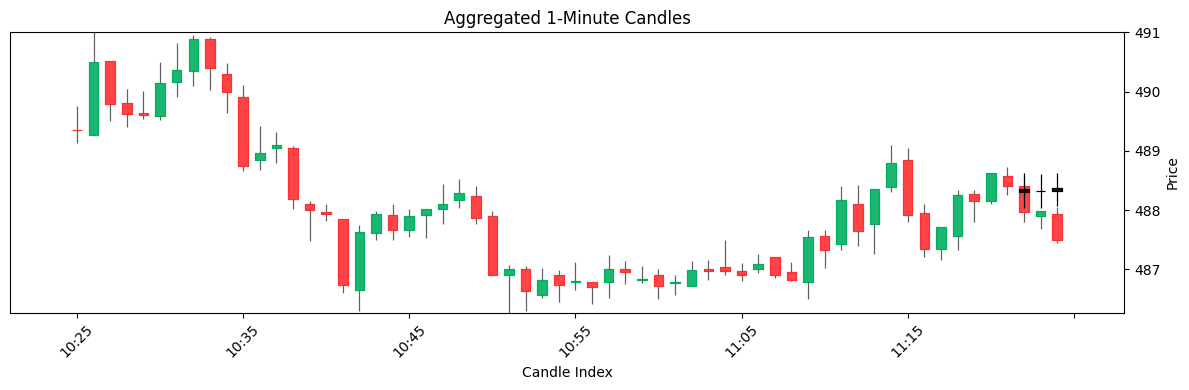

V 2023-03-13: 03:52 PM
Base Loss for first 4 columns: 0.35331544280052185
Body Losses: tensor([0.0803, 0.0205, 0.3845])
Old Custom Loss: 0.5167524814605713
New Custom Loss: 0.505504846572876


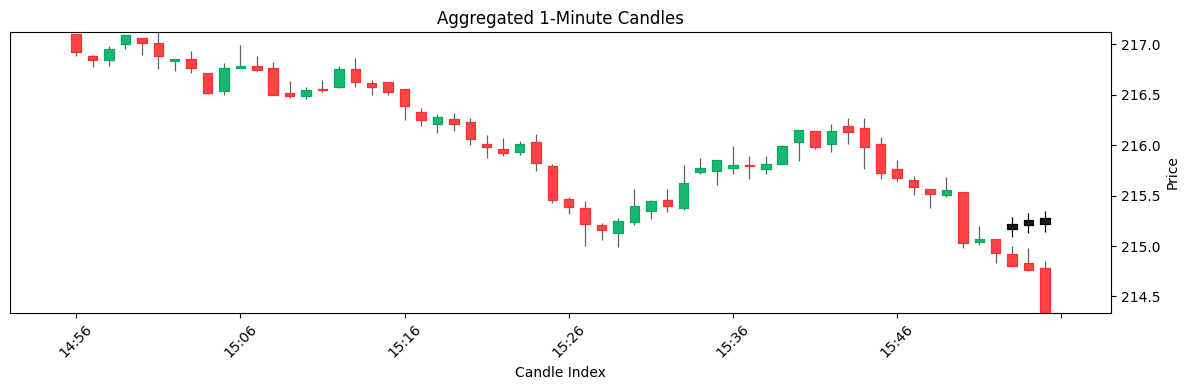

In [133]:
# Get 10 examples for testing the plotting the model's performance
for i in range(1, len(test_dataset), (len(test_dataset) - 1) // 10):
    _test_example = test_dataset[i]
    infer_and_plot(_test_example)
    

## Custom Loss Function

We want to design a custom loss function, which will encourage the model to also prioritize teh structure of the candle bodies as well as there relationship between candles. We are going to devise a new custom $MSE$ and $MAE$ loss functions, denoted $cMSE$ and $cMAE$. 

In [372]:
def infer_and_compute_loss(example: dict) -> Tuple[pd.Timestamp, torch.Tensor, torch.Tensor]:
    # Get the metadata for the example
    ticker, date_str = example['id']
    ts = pd.Timestamp(example['timestamp']).tz_localize("UTC").tz_convert("America/New_York")

    # Get an example for inference
    _context = example['past_values']
    _futures = example['future_values']

    # Get the forecasts
    _forecasts = run_inference(_context, _futures)

    mse = torch.nn.functional.mse_loss(_forecasts[:, :5], _futures[:, :5])
    mae = torch.nn.functional.l1_loss(_forecasts[:, :5], _futures[:, :5])
    
    # Compute the loss
    base_loss = (mae + mse) / 2
    loss = custom_loss(_forecasts, _futures[:, :5])

    return {
        'timestamp': ts, 
        'ticker': ticker,
        "base_loss": base_loss.item(), 
        "custom_loss": loss.item()
    }

In [30]:
scaled_test_tsp = TimeSeriesPreprocessor(
    timestamp_column=timestamp_col,
    id_columns=id_columns,
    target_columns=forecast_columns,
    control_columns=control_columns,
    observable_columns=observable_columns,
    scaling=True,
)
scaled_test_tsp.train(test_data)

scaled_test_dataset = ForecastDFDataset(
    scaled_test_tsp.preprocess(test_data),
    id_columns=id_columns,
    timestamp_column=timestamp_col,
    target_columns=forecast_columns,
    control_columns=control_columns,
    observable_columns=observable_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)

In [31]:
from tqdm import tqdm
from torch.utils.data import DataLoader


def custom_collate_fn(batch):
    # Initialize an empty dictionary to store the collated batch
    collated_batch = {}

    # Iterate over the keys in the first sample of the batch
    for key in batch[0].keys():
        # Collate the values for each key
        if key in ["past_values", "future_values", "static_categorical_values"]:
            # Stack the tensors along a new batch dimension
            collated_batch[key] = torch.stack([sample[key] for sample in batch], dim=0)
        elif key == "timestamp":
            # Combine the timestamp values into a list
            collated_batch[key] = [sample[key] for sample in batch]
        elif key == "id":
            # Combine the group IDs into a list
            collated_batch[key] = [sample[key] for sample in batch]
        elif key == "freq_token":
            # Stack the frequency tokens into a tensor
            collated_batch[key] = torch.stack([sample[key] for sample in batch], dim=0)
        else:
            raise ValueError(f"Unexpected key '{key}' in the batch.")

    return collated_batch

# Create a DataLoader
test_dataloader = DataLoader(
    scaled_test_dataset,
    batch_size=512,  # Specify the desired batch size
    shuffle=False,  # Set to False for evaluation/testing
    num_workers=4,  # Number of worker processes for data loading
    collate_fn=custom_collate_fn,  # Pass the custom collate function
)

In [32]:
# Iterate over the batches
model.to('cuda')

all_futures = []
all_forecasts = []

for batch in tqdm(test_dataloader, total=len(test_dataloader)):
    context = batch['past_values'].to('cuda')
    futures = batch['future_values'].to('cuda')

    with torch.no_grad():
        forecasts = model(context).prediction_outputs

    all_futures.append(futures.to('cpu'))
    all_forecasts.append(forecasts.to('cpu'))

# Concatenate all futures and forecasts tensors
all_futures = torch.cat(all_futures, dim=0)
all_forecasts = torch.cat(all_forecasts, dim=0)
        

100%|██████████| 142/142 [00:18<00:00,  7.54it/s]


In [35]:
# Now, let's plot the loss of the model, by timestamp, and ticker
# We will want to create 10 different time-series (one for each ticker) and
# an eleventh, that will represent the average loss of all tickers for each 
# timestamp
loss = custom_loss(forecasts, futures[..., :5])
loss


tensor(0.2989, device='cuda:0')

### Sanity Check on Error Computations

Let's ensure that the loss functions are correctly computing the loss values

In [348]:
example = test_dataset[1]
context = example['past_values']
futures = example['future_values']

forecasts = run_inference(context, futures)

Ran Inference in 0.019745849996979814 seconds


In [242]:
reals_df, forecasts_df = post_process(context, futures, forecasts)
forecasts_df

,Open,Close,High,Low
0,138.125656,138.127808,138.224121,137.981232
1,138.119080,138.116470,138.210632,137.980057
2,138.109802,138.110291,138.197464,137.977356


In [243]:
futures_df = reals_df.iloc[-3:]
futures_df

,Open,Close,High,Low
0,138.119995,138.190002,138.270004,137.899994
1,138.195007,138.891998,138.960007,138.179993
2,138.875000,139.209900,139.220001,138.779999


In [246]:
# Compute the body error
forecasts_bodies = forecasts_df.Open - forecasts_df.Close
futures_bodies = futures_df.Open - futures_df.Close

ae = (futures_bodies - forecasts_bodies).abs().mean()
se = (futures_bodies - forecasts_bodies).pow(2).mean()

computed_se, computed_ae = theta_body(forecasts, futures)

(ae, se), (torch.mean(computed_ae), torch.mean(computed_se))

((0.36728922, 0.20195867), (tensor(0.3673), tensor(0.2020)))

In [249]:
# Compute the Wick High Error
forecasts_wick_h = forecasts_df.High - forecasts_df[['Open', 'Close']].max(axis=1)
futures_wick_h = futures_df.High - futures_df[['Open', 'Close']].max(axis=1)

ae = (futures_wick_h - forecasts_wick_h).abs().mean()
se = (futures_wick_h - forecasts_wick_h).pow(2).mean()
ae, se

computed_se, computed_ae = theta_wick_h(forecasts, futures, torch.max(forecasts[:, [I_OPEN, I_CLOSE]], dim=1)[0], torch.max(futures[:, [I_OPEN, I_CLOSE]], dim=1)[0])

(ae, se), (torch.mean(computed_ae), torch.mean(computed_se))

((0.038976032, 0.0022535066), (tensor(0.0390), tensor(0.0023)))

In [250]:
# Compute the Wick Low Error
forecasts_wick_l =  forecasts_df[['Open', 'Close']].min(axis=1) - forecasts_df.Low
futures_wick_l = futures_df[['Open', 'Close']].min(axis=1) - futures_df.Low

ae = (futures_wick_l - forecasts_wick_l).abs().mean()
se = (futures_wick_l - forecasts_wick_l).pow(2).mean()
ae, se

computed_se, computed_ae = theta_wick_l(forecasts, futures, torch.min(forecasts[:, [I_OPEN, I_CLOSE]], dim=1)[0], torch.min(futures[:, [I_OPEN, I_CLOSE]], dim=1)[0])

(ae, se), (torch.mean(computed_ae), torch.mean(computed_se))

((0.07814026, 0.007283894), (tensor(0.0781), tensor(0.0073)))